In [16]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from keras.datasets import mnist
import keras
from keras import layers
import math


In [17]:
loadedData=mnist.load_data()

In [18]:
(x_train,y_train),(x_test,y_test)=loadedData
# the shape of the datas
print(x_train.shape)
print(y_train.shape)

(60000, 28, 28)
(60000,)


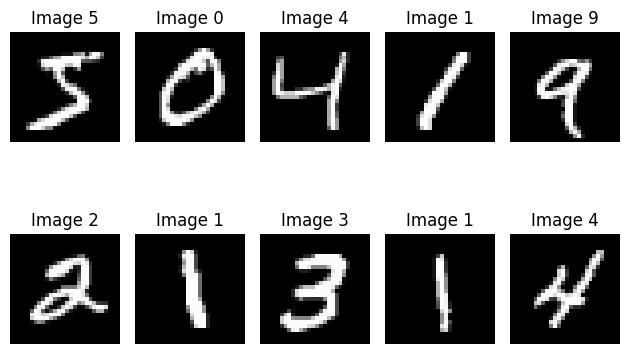

In [19]:
# print the train data
sample_indices=np.random.randint(low=0, high=30, size=10)

# plot the training images
num_columns=5
num_rows=math.ceil(sample_indices.shape[0]/num_columns)
fig,axes=plt.subplots(num_rows,num_columns)

for x in range(sample_indices.shape[0]):
  row_index = x // num_columns
  column_index=x%num_columns
  image=x_train[x]
  # print(row_index,column_index)
  axes[row_index,column_index].imshow(image,cmap='gray')
  axes[row_index,column_index].set_title(f'Image {y_train[x]}')
  axes[row_index,column_index].axis('off')
# Hide empty subplots, if any
for i in range(sample_indices.shape[0], num_rows * num_columns):
    row_index = i // num_columns
    col_index = i % num_columns
    fig.delaxes(axes[row_index, col_index])

# automatically adjust the space
plt.tight_layout()
# plt.subplots_adjust(hspace=0.5,wspace=0.5)
plt.show()


In [20]:
# splitting the training data into train and validation as we already have the test data
from sklearn.model_selection import train_test_split
X_train,X_validation,Y_train,Y_validation=train_test_split(x_train,y_train,test_size=0.2,shuffle=True)

# reshape

X_train=X_train.reshape(X_train.shape[0],X_train.shape[1],X_train.shape[2],1)
X_validation=X_validation.reshape(X_validation.shape[0],X_validation.shape[1],X_validation.shape[2],1)
X_test=x_test.reshape(x_test.shape[0],x_test.shape[1],x_test.shape[2],1)

In [21]:
print(X_train.shape, Y_train.shape)
print(X_validation.shape, Y_validation.shape)
print(x_test.shape, x_test.shape)
# normalizing the train and validation
X_train_norm=X_train.astype('float32')/255.0
X_validation_norm=X_validation.astype('float32')/255.0

(48000, 28, 28, 1) (48000,)
(12000, 28, 28, 1) (12000,)
(10000, 28, 28) (10000, 28, 28)


In [22]:
# defining the layers
input = keras.Input((X_train.shape[1], X_train.shape[2], 1))
conv2D = keras.layers.Conv2D(64, kernel_size=(3, 3), activation="relu", kernel_initializer='glorot_normal', name='ConvLayer1')(input)
conv2D = keras.layers.Conv2D(64, kernel_size=(3, 3), activation="relu", kernel_initializer='glorot_normal', name='ConvLayer2')(conv2D)
maxPool = keras.layers.MaxPool2D(pool_size=(2, 2), name='MaxPoolLayer1')(conv2D)
batchnorm = keras.layers.BatchNormalization()(maxPool)
conv2D = keras.layers.Conv2D(128, 3, activation='relu', kernel_initializer='glorot_normal', name='ConvLayer3')(batchnorm)
conv2D = keras.layers.Conv2D(128, 3, activation='relu', kernel_initializer='glorot_normal', name='ConvLayer4')(conv2D)
maxPool = keras.layers.MaxPool2D(pool_size=(2, 2), name='MaxPoolLayer2')(conv2D)
batchnorm = keras.layers.BatchNormalization()(maxPool)
flatten = keras.layers.Flatten()(batchnorm)
outputs = keras.layers.Dense(units=256, activation='relu')(flatten)
# dropout=keras.layers.Dropout(0.2)(outputs)
outputs = keras.layers.Dense(units=10, activation='softmax')(outputs)



In [23]:

# creating the model
model=keras.Model(inputs=input,outputs=outputs)
model.compile(optimizer=tf.keras.optimizers.Adam(0.001),loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),metrics=['accuracy'])
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 ConvLayer1 (Conv2D)         (None, 26, 26, 64)        640       
                                                                 
 ConvLayer2 (Conv2D)         (None, 24, 24, 64)        36928     
                                                                 
 MaxPoolLayer1 (MaxPooling2  (None, 12, 12, 64)        0         
 D)                                                              
                                                                 
 batch_normalization_4 (Bat  (None, 12, 12, 64)        256       
 chNormalization)                                                
                                                                 
 ConvLayer3 (Conv2D)         (None, 10, 10, 128)       7385

In [24]:
# With data augmentation to prevent overfitting

datagen = keras.preprocessing.image.ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=15,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.01, # Randomly zoom image
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images


#datagen.fit(X_train)
train_gen = datagen.flow(X_train_norm, Y_train, batch_size=128)
validation_generation = datagen.flow(X_validation_norm, Y_validation, batch_size=128)

In [28]:
epochs = 10
batch_size = 128
train_steps = X_train_norm.shape[0] // batch_size
valid_steps = X_validation_norm.shape[0] // batch_size

es = keras.callbacks.EarlyStopping(
        monitor="accuracy", # metrics to monitor
        patience=10, # how many epochs before stop
        verbose=1,
        mode="max", # we need the maximum accuracy.
        restore_best_weights=True, #
     )

rp = keras.callbacks.ReduceLROnPlateau(
        monitor="accuracy",
        factor=0.2,
        patience=3,
        verbose=1,
        mode="max",
        min_lr=0.00001,
     )

In [29]:
# one way
# trainDataset=tf.data.Dataset.from_tensor_slices((X_train,Y_train)).batch(64)
# validationDataset=tf.data.Dataset.from_tensor_slices((X_validation,Y_validation)).batch(64)
# history=model.fit(X_train_norm,Y_train,epochs=10,validation_data=(X_validation_norm,Y_validation))
history=model.fit(train_gen,
                              epochs = epochs,
                              steps_per_epoch = train_steps,
                              validation_data = validation_generation,
                              validation_steps = valid_steps,
                              callbacks=[es, rp])

Epoch 1/10
375/375 [==============================] - 28s 74ms/step - loss: 0.0125 - accuracy: 0.9960 - val_loss: 0.0279 - val_accuracy: 0.9934 - lr: 2.0000e-04
Epoch 2/10
375/375 [==============================] - 20s 54ms/step - loss: 0.0105 - accuracy: 0.9969 - val_loss: 0.0252 - val_accuracy: 0.9934 - lr: 2.0000e-04
Epoch 3/10
375/375 [==============================] - 23s 62ms/step - loss: 0.0080 - accuracy: 0.9975 - val_loss: 0.0242 - val_accuracy: 0.9940 - lr: 2.0000e-04
Epoch 4/10
375/375 [==============================] - 21s 57ms/step - loss: 0.0078 - accuracy: 0.9976 - val_loss: 0.0208 - val_accuracy: 0.9945 - lr: 2.0000e-04
Epoch 5/10
375/375 [==============================] - 22s 59ms/step - loss: 0.0063 - accuracy: 0.9980 - val_loss: 0.0235 - val_accuracy: 0.9937 - lr: 2.0000e-04
Epoch 6/10
375/375 [==============================] - 23s 60ms/step - loss: 0.0065 - accuracy: 0.9981 - val_loss: 0.0243 - val_accuracy: 0.9940 - lr: 2.0000e-04
Epoch 7/10
375/375 [==============

In [30]:
test_loss,test_accuracy=model.evaluate(X_test.astype('float32')/255.0,y_test)
# test_loss,test_accuracy=model.evaluate(validation_generation)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

313/313 [==============================] - 1s 4ms/step - loss: 0.0145 - accuracy: 0.9967
Test Loss: 0.014472314156591892
Test Accuracy: 0.9966999888420105


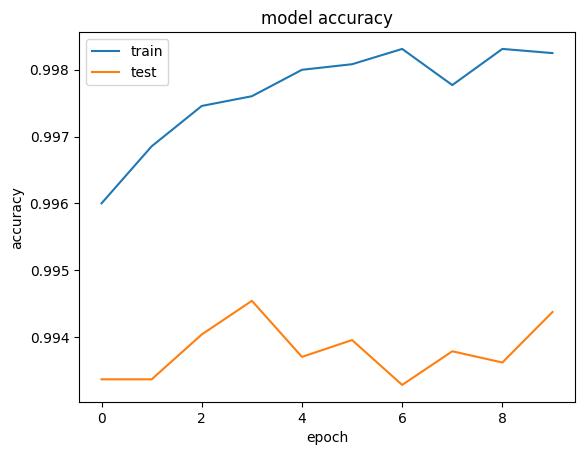

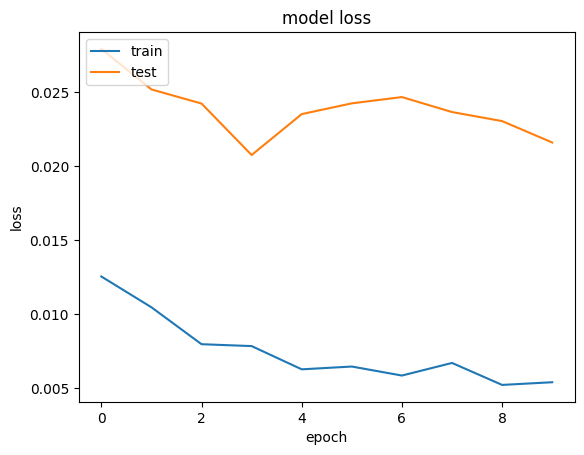

In [151]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

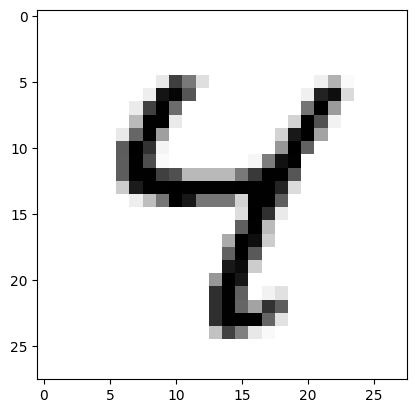

In [31]:
plt.imshow(X_test[6].reshape((28,28)), cmap=plt.cm.binary)
plt.show()

In [119]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [38]:
predictions=model.predict(X_test.astype('float32')/255.0)
predictions=np.argmax(predictions, axis=1)


313/313 [==============================] - 1s 3ms/step


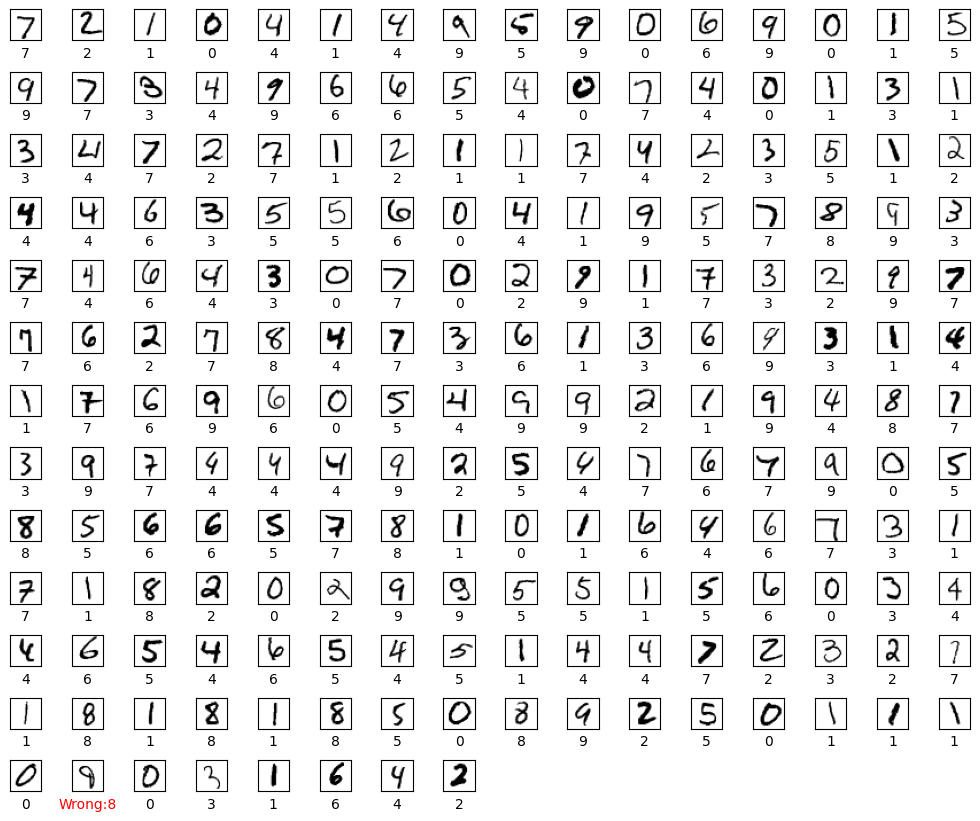

In [39]:
# for i in range(X_test.shape[0])
random_plot_indices=tf.random.uniform([200],dtype=tf.int64,minval=0,maxval=X_test.shape[1])
plt.figure(figsize=(10,10))
for i in range(random_plot_indices.shape[0]):
  plt.subplot(16,16,i+1)
  image=X_test[i]
  label=y_test[i]
  predicted_label=predictions[i]
  # Check if the label matches the predicted label
  x_label = str(predictions[i]) if label == predicted_label else 'Wrong:' + str(predictions[i])

  # Display the image in black and white
  plt.imshow(image, cmap=plt.cm.binary)

  # Set label
  plt.xlabel(x_label, color='red' if label != predicted_label else 'black')

  # Hide axis ticks
  plt.xticks([])
  plt.yticks([])

  # Hide grid
  plt.grid(False)

plt.tight_layout()
plt.subplots_adjust(hspace=1,wspace=0.5)
plt.show()

In [40]:
type(predictions)
type(y_test)

numpy.ndarray

In [41]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

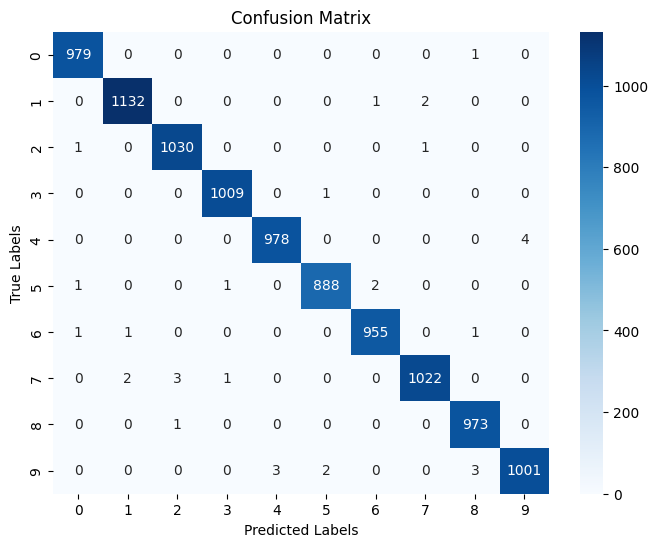

In [42]:
cm = confusion_matrix(y_test, predictions)

# Create a heatmap for the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [93]:
# test on the custom photos
# /content/drive/MyDrive/Digits images/1.jpeg
import cv2
from scipy import ndimage
def preprocess_image(image_path):
    # Read the image
    gray = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    # Resize the image and invert it (black background)
    gray = cv2.resize(255 - gray, (28, 28))
    _, gray = cv2.threshold(gray, 128, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)

    # Process the image to remove empty borders
    while np.sum(gray[0]) == 0:
        gray = gray[1:]

    while np.sum(gray[:, 0]) == 0:
        gray = np.delete(gray, 0, 1)

    while np.sum(gray[-1]) == 0:
        gray = gray[:-1]

    while np.sum(gray[:, -1]) == 0:
        gray = np.delete(gray, -1, 1)

    rows, cols = gray.shape

    # Resize the image to 28x28 maintaining aspect ratio
    if rows > cols:
        factor = 20.0 / rows
        rows = 20
        cols = int(round(cols * factor))
        gray = cv2.resize(gray, (cols, rows))
    else:
        factor = 20.0 / cols
        cols = 20
        rows = int(round(rows * factor))
        gray = cv2.resize(gray, (cols, rows))

    cols_padding = (int(math.ceil((28 - cols) / 2.0)), int(math.floor((28 - cols) / 2.0)))
    rows_padding = (int(math.ceil((28 - rows) / 2.0)), int(math.floor((28 - rows) / 2.0)))
    gray = np.lib.pad(gray, (rows_padding, cols_padding), 'constant')

    return gray  # Flatten and normalize

In [100]:
def getBestShift(img):
    cy,cx = ndimage.center_of_mass(img)

    rows,cols = img.shape
    shiftx = np.round(cols/2.0-cx).astype(int)
    shifty = np.round(rows/2.0-cy).astype(int)

    return shiftx,shifty
def shift(img,sx,sy):
    rows,cols = img.shape
    M = np.float32([[1,0,sx],[0,1,sy]])
    shifted = cv2.warpAffine(img,M,(cols,rows))
    return shifted

1/1 [==============================] - 0s 54ms/step


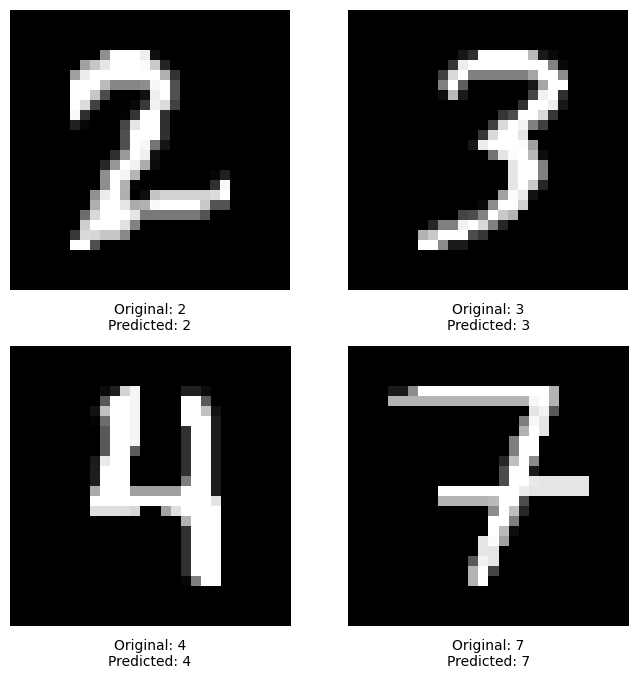

In [150]:
image_paths_indices = [
    (2, '/content/drive/MyDrive/test digit/2.jpeg'),
    (3, '/content/drive/MyDrive/test digit/3.jpeg'),
    (4, '/content/drive/MyDrive/test digit/4.jpeg'),
    (7, '/content/drive/MyDrive/test digit/7.jpeg')
]

fig, axs = plt.subplots(2, 2, figsize=(8, 8))


for i, (original_digit, image_path) in enumerate(image_paths_indices):
    # Preprocess the image
    image_to_test = preprocess_image(image_path)

    # using the  shift for visualization
    # shiftx, shifty = getBestShift(image_to_test)
    # shifted = shift(image_to_test, shiftx, shifty)
    gray = image_to_test

    # reshaping the image for prediction
    prediction_input = gray.reshape((-1, 28, 28, 1))

    prediction_probs = model.predict(prediction_input)
    predicted_digit = np.argmax(prediction_probs)


    plt.subplot(2, 2, i + 1)
    plt.imshow(gray, cmap='gray')
    plt.text(0.5, -0.1, f'Original: {original_digit}\nPredicted: {predicted_digit}',
             horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
    plt.axis('off')

plt.show()

In [149]:
model.save("model.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
